In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/master/init.py
import init; init.init(force_download=False);
from IPython.display import Image

replicating local resources


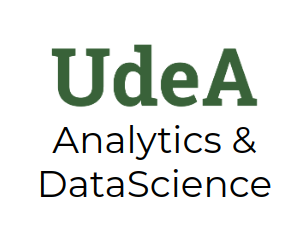

In [ ]:
Image("local/imgs/udea-datascience.png")

In [ ]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

#SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

In [ ]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import pyspark.sql.functions as F

# **TALLER 2: DataFrame**
## Desarrollado por: Mg. Efraín Alberto Oviedo; Ing. Kevin Martínez Gallego
## Universidad de Antioquia

Por favor, ingrese la información de cada integrante del grupo de trabajo

**Nombre Completo:** Henry Alberto Arcila - Jairo Agudelo M

**Cédula:** 70698438 - 98583652

**Correo Institucional:** henry.arcila@udea.edu.co - jairo.agudelom@udea.edu.co

#**Análisis de becas académicas para estudiantes Colombianos**

El ICETEX ha dispuesto un histórico de becas ofrecidas para estudios de nivel de pregrado y posgrado, presenciales o virtuales, que han sido propuestas para fortalecer la formación académica de ciudadanos colombianos en el exterior.

(Disponible en https://www.datos.gov.co/Educaci-n/Icetex-Hist-rico-de-Becas/eb6r-dfgr)

Para cada caso se reportan los siguientes datos:

* Código Convocatoria
* Nombre del Oferente: Nombre del gobierno que ofrece la beca.
* Área del Conocimiento
* Nombre del Programa
* Nombre del País
* Fecha de Recepción -mm/dd/aaaa
* Perfil del Aplicante
* Objetivo del Programa: Breve descripción del programa académico.

Se solicita de su ayuda para responder a los siguientes interrogantes:

In [ ]:
# Carga del dataframe
icetex_becas = spark.read.csv('local/data/icetex_becas.csv',
                              header=True,
                              inferSchema=True)

In [ ]:
# Cantidad de registros
icetex_becas.count()

1485

In [ ]:
# Columnas (Caracteristica) del dataframe
icetex_becas.columns

['Codigo Convocatoria',
 'Nombre del Oferente',
 'Area del Conocimiento',
 'Nombre del programa',
 'Nombre del País',
 'Fecha de Recepción -mm/dd/aaaa',
 'Perfil del Aplicante',
 'Objetivo del Programa']

In [ ]:
# Numero de caracteristicas de cada registro
len(icetex_becas.columns)

8

In [ ]:
# Tipos de datos de cada caracteristica
icetex_becas.dtypes

[('Codigo Convocatoria', 'double'),
 ('Nombre del Oferente', 'string'),
 ('Area del Conocimiento', 'string'),
 ('Nombre del programa', 'string'),
 ('Nombre del País', 'string'),
 ('Fecha de Recepción -mm/dd/aaaa', 'string'),
 ('Perfil del Aplicante', 'string'),
 ('Objetivo del Programa', 'string')]

Como las columnas tienen espacios y tildes y otro tipo de caracteres que pueden dificultar el acceso a estas, se van a renombrar.

## **A) Calidad de datos**

Revise cada una de las variables disponibles y resuelva los problemas de calidad de datos que puedan afectar el desarrollo de este taller, justificando las razones de su decisión para cada caso


### Solución

Inicialmente se renombraron las columnas

In [ ]:
from unicodedata import normalize

In [ ]:
# Normalizacion de los nombres de las columnas
new_columns = [col.replace(" ", "_").lower() for col in icetex_becas.columns]
new_columns[5] = new_columns[5].split("-")[0]
new_columns[5] = new_columns[5][:-1]
new_columns = [normalize('NFKD', col).encode('ASCII', 'ignore').decode('utf-8') for col in new_columns]
new_columns


['codigo_convocatoria',
 'nombre_del_oferente',
 'area_del_conocimiento',
 'nombre_del_programa',
 'nombre_del_pais',
 'fecha_de_recepcion',
 'perfil_del_aplicante',
 'objetivo_del_programa']

In [ ]:
# Nombre actual de las columnas
icetex_becas.columns

['Codigo Convocatoria',
 'Nombre del Oferente',
 'Area del Conocimiento',
 'Nombre del programa',
 'Nombre del País',
 'Fecha de Recepción -mm/dd/aaaa',
 'Perfil del Aplicante',
 'Objetivo del Programa']

In [ ]:
# Diccionario con los nombres antiguos de las columnas como clave y lo nuevos nombres de las columnas como valor
nuevos_nombres = dict(zip(icetex_becas.columns, new_columns))
nuevos_nombres

{'Codigo Convocatoria': 'codigo_convocatoria',
 'Nombre del Oferente': 'nombre_del_oferente',
 'Area del Conocimiento': 'area_del_conocimiento',
 'Nombre del programa': 'nombre_del_programa',
 'Nombre del País': 'nombre_del_pais',
 'Fecha de Recepción -mm/dd/aaaa': 'fecha_de_recepcion',
 'Perfil del Aplicante': 'perfil_del_aplicante',
 'Objetivo del Programa': 'objetivo_del_programa'}

In [ ]:
# Renombrado de las columas usando el diccionario

icetex_becas = icetex_becas.select([icetex_becas[c].alias(nuevos_nombres[c]) for c in icetex_becas.columns])

# Despliegue de los nombres de las columnas
icetex_becas.columns

['codigo_convocatoria',
 'nombre_del_oferente',
 'area_del_conocimiento',
 'nombre_del_programa',
 'nombre_del_pais',
 'fecha_de_recepcion',
 'perfil_del_aplicante',
 'objetivo_del_programa']

In [ ]:
# Inspeccion de los 5 primeros registros del dataframe
icetex_becas.show(5)

+-------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|codigo_convocatoria| nombre_del_oferente|area_del_conocimiento| nombre_del_programa|     nombre_del_pais|  fecha_de_recepcion|perfil_del_aplicante|objetivo_del_programa|
+-------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|          2127916.0|OEA - TOP - ARGEN...|       ADMINISTRACIÓN|POLÍTICAS DE GOBI...|PLATAFORMA DE EDU...|05/27/2016 12:00:...|El programa está ...| a) Proporcionar a...|
|          3101616.0|ALIANZA DEL PACÍF...|     DIFERENTES AREAS|PLATAFORMA DE MOV...|Chile (República ...|                null|El programa está ...| El objetivo del P...|
|          2221414.0|GOBIERNO DE LA INDIA|  INGENIERIA Y AFINES|DATA COMMUNICATIO...|India (República ...|07/30/2014 12:00:...|"El Programa ""Co.

**Conclusión**: Inicialmente solo se han renombrado las columnas.

## **B) Aumento de ofertas de becas**

Identifique si la cantidad de becas ofrecidas para ciudadanos colombianos se ha incrementado con los años

### Solucion

Seleccion de la columna de interes (Fecha de las becas).

In [ ]:
# Registro del DataFrame como una tabla temporal
icetex_becas.registerTempTable("becas_icetex")

# Seleccion de la columna fecha
sql_query = """
		        SELECT fecha_de_recepcion
		        FROM becas_icetex
		        """

fechas_becas = sqlCtx.sql(sql_query)
fechas_becas.show(n = 3)

+--------------------+
|  fecha_de_recepcion|
+--------------------+
|05/27/2016 12:00:...|
|                null|
|07/30/2014 12:00:...|
+--------------------+
only showing top 3 rows



Desarrollo de una funcion para obtener unicamente a partir de la información de la fecha

In [ ]:
def obtener_anho(fecha):
  """
  Obtiene el año de una fecha en formato 'mm/dd/yyyy *'
  """
  return fecha.split()[0].split('/')[-1]

DEBUG = True

# Test de la funcion
if DEBUG:
  f = "05/27/2016 12:00"
  print(obtener_anho(f))

2016


In [ ]:
# Registrar la función como UDF (User Defined Fuction)
obtener_anho_udf = udf(obtener_anho, StringType())

Conteo de registros nulos

In [ ]:
# Catidad de registros nulos
fechas_becas.where(fechas_becas["fecha_de_recepcion"].isNull()).count()

647

Realizando la limpieza de registros nulos

In [ ]:
fechas_becas_limpias = fechas_becas.dropna(subset=["fecha_de_recepcion"])

In [ ]:
# Obtencion de los años
fechas_becas_limpias = fechas_becas_limpias.withColumn("anho", obtener_anho_udf(fechas_becas_limpias["fecha_de_recepcion"]))
fechas_becas_limpias.show(3)

# Conteo de registros por año
fechas_becas_limpias.groupBy("anho").count().orderBy("anho").show()

+--------------------+----+
|  fecha_de_recepcion|anho|
+--------------------+----+
|05/27/2016 12:00:...|2016|
|07/30/2014 12:00:...|2014|
|07/26/2013 12:00:...|2013|
+--------------------+----+
only showing top 3 rows

+----+-----+
|anho|count|
+----+-----+
|2011|  126|
|2012|  135|
|2013|  121|
|2014|  165|
|2015|  114|
|2016|  177|
+----+-----+



In [ ]:
print(f"Registros totales [Sin eliminar vacios]: {fechas_becas.count()}")
print(f"Registros totales [Eliminando vacios]: {fechas_becas_limpias.count()}")

Registros totales [Sin eliminar vacios]: 1485
Registros totales [Eliminando vacios]: 838


**Conclusiones**:
1. Aunque hay un incremento del primer al ultimo año, no necesariamente implico incrementos año a año.
2. Hay que tener en cuenta cerca de la mitad de los registros no tenian informacion de la fecha por lo que esta afirmación no es lo suficientemente concluyente.

##**C) Paises que han ofrecido becas**

Presente un listado con todos los países (diferentes de Colombia) de los que se tiene reporte que han ofrecido becas para estudiantes colombianos (*solamente presentar nombres de países, y estos solo deben aparecer una única vez en la lista*)

### Solución

In [ ]:
sql_query = """
		        SELECT nombre_del_pais
		        FROM becas_icetex
		        """
paises_becas = sqlCtx.sql(sql_query)

In [ ]:
# Cacheando el dataframe leido para acelerar los calculos
paises_becas_cached = paises_becas.cache()

In [ ]:
# Verificando si hay registros vacios en el dataframe obtenido
paises_becas_cached.where(paises_becas_cached["nombre_del_pais"].isNull()).count()

0

In [ ]:
# Se cuentan en numero de registros distintos
paises_becas_cached.distinct().count()

55

In [ ]:
# Despliegue de los 10 primeros registros
paises_becas_cached.distinct().show(10)

+--------------------+
|     nombre_del_pais|
+--------------------+
|Italia (República...|
|Suecia (Reino de ...|
|Corea del Sur (Re...|
|Rusia (Federación...|
|Paraguay (Repúbli...|
|Australia (Mancom...|
|Estados Unidos (E...|
|     Belice (Belice)|
|PLATAFORMA DE EDU...|
|       Japón (Japón)|
+--------------------+
only showing top 10 rows



Como los paises que aparecen tienen diferentes formatos, lo primero que se hizo fue una funcion de usuario para realizar la limpieza de estos registros colocandolos en un formato mas uniforme. A continuación se resaltan algunos de los diferentes casos de formatos encontrados:
* `PLATAFORMA DE EDUCACIÓN A DISTANCIA TOP - OEA`
* `India (República de India)	`
* `ALIANZA DEL PACÍFICO-CHILE-MÉXICO-PERÚ`

In [ ]:
# Previamente se importo pyspark.sql.functions como F para abreviar la invocacion de las funciones

# Remocion de parentesis de los registros de la columna 'nombre_del_pais' nombres llevando el resultado a una nueva columna llamada 'pais'
paises_becas_cached = paises_becas_cached.withColumn("pais", F.split(paises_becas_cached.nombre_del_pais,r"\(")[0])
# Remocion de espacios en la columna 'pais'
paises_becas_cached = paises_becas_cached.withColumn("pais", F.trim(paises_becas_cached.pais))

In [ ]:
# Inspeccion del resultado
paises_becas_cached.show(10)

+--------------------+--------------------+
|     nombre_del_pais|                pais|
+--------------------+--------------------+
|PLATAFORMA DE EDU...|PLATAFORMA DE EDU...|
|Chile (República ...|               Chile|
|India (República ...|               India|
|     Canadá (Canadá)|              Canadá|
|Perú (República d...|                Perú|
|India (República ...|               India|
|   Diferentes Países|   Diferentes Países|
|China (República ...|               China|
|       Japón (Japón)|               Japón|
|España (Reino de ...|              España|
+--------------------+--------------------+
only showing top 10 rows



Como aun registros con el nombre de varios paises como `Estados Unidos Mexicanos EspaÃ±a y Alemania` se hizo una nueva función para tratar esta situación y alguna otra similas. La función se muestra a continuación y de define como una función UDF.

In [ ]:
# India (RepÃºblica de India)

def obtener_pais(pais):
  if "PLATAFORMA" in pais:
    return pais
  elif "Estados" in pais:
    if pais == "Estados Unidos":
      return pais
    else:
      return "Diferentes Países"
  else:
    return pais

# Registrar la función como UDF
obtener_pais_udf = udf(obtener_pais, StringType())

In [ ]:
# Aplicación de la función anterior a la columna pais
paises_becas_cached = paises_becas_cached.withColumn("pais", obtener_pais_udf(paises_becas_cached["pais"]))

In [ ]:
# Inspección del resultado
paises_becas_cached.show(10)

+--------------------+--------------------+
|     nombre_del_pais|                pais|
+--------------------+--------------------+
|PLATAFORMA DE EDU...|PLATAFORMA DE EDU...|
|Chile (República ...|               Chile|
|India (República ...|               India|
|     Canadá (Canadá)|              Canadá|
|Perú (República d...|                Perú|
|India (República ...|               India|
|   Diferentes Países|   Diferentes Países|
|China (República ...|               China|
|       Japón (Japón)|               Japón|
|España (Reino de ...|              España|
+--------------------+--------------------+
only showing top 10 rows



In [ ]:
# Se remueve la columna no necesaria
paises_becas_cached.drop("nombre_del_pais")
# Remocion de Colombia de la lista
paises_becas_cached = paises_becas_cached.filter(paises_becas_cached["pais"] != "Colombia")

In [ ]:
# Inspección del resultado
paises_becas_cached.groupBy("pais").count().orderBy("count", ascending=False).show(10) #.select('pais').show(paises_becas_cached.count())

+--------------------+-----+
|                pais|count|
+--------------------+-----+
|               India|  223|
|              Israel|  184|
|              España|  166|
|                Perú|   91|
|       Corea del Sur|   86|
|PLATAFORMA DE EDU...|   78|
|         Reino Unido|   51|
|              Egipto|   48|
|               Japón|   46|
|PLATAFORMA DE EDU...|   42|
+--------------------+-----+
only showing top 10 rows



Finalmente, el resultado solicitado se muestra a continuación:

In [ ]:
paises_becas_cached.groupBy("pais").count().orderBy("pais", ascending=True).select('pais').show(paises_becas_cached.count())

+--------------------+
|                pais|
+--------------------+
|           Argentina|
|           Australia|
|Barbados Jamaica ...|
|              Belice|
|              Brasil|
|              Brunéi|
|             Bélgica|
|              Canadá|
|          Checa Rep.|
|               Chile|
|               China|
|       Corea del Sur|
|          Costa Rica|
|   Diferentes Países|
|             Ecuador|
|              Egipto|
|              España|
|      Estados Unidos|
|             Francia|
|            Honduras|
|             Hungría|
|               India|
|           Indonesia|
|              Israel|
|              Italia|
|               Japón|
|             Malasia|
|              México|
|           Nicaragua|
|       Nueva Zelanda|
|PLATAFORMA DE EDU...|
|PLATAFORMA DE EDU...|
|PLATAFORMA DE EDU...|
|PLATAFORMA DE EDU...|
|PLATAFORMA DE EDU...|
|              Panamá|
|            Paraguay|
|                Perú|
|Plataforma de edu...|
|             Polonia|
|         P

In [ ]:
# Se libera el DataFrame cacheado
paises_becas_cached.unpersist()
paises_becas_cached.is_cached

False

**Conclusiones**: Se realizo una limpieza de datos para mostrar los paises que ofrecieron becas.

##**D) Áreas del conocimiento y Posgrados**

Se desea averiguar cúal es el área de conocimiento predominante por país. Además, queremos conocer qué porcentaje de los programas ofrecidos (**de acuerdo al nombre del programa**) corresponden a estudios de posgrado.

### Solución

Inicialmente vamos a realizar una función simple para que permita identificar si una carrera es de posgrado o pregrado.

In [ ]:
# "INGENIERIA Y ADMINISTRACION"
# "ADMINISTRACIÃ“N - ECONOMÃA"

def obtener_titulacion(area):
  """
  Determina si una carrera es de posgrado o pregrado
  """
  if "MAESTR" in area or "POSGR" in area or "DOCTORADO" in area:
    return "posgrado"
  else:
    return "pregrado"

Tambien vamos a realizar una funcion para obtener el pais (un poco diferente de la que se empleo anteriormente) y la vamos a registrar para que pueda ser usada como SQL:

In [ ]:
def obtener_pais2(pais):
  """
  Obtiene el año de una fecha en formato 'mm/dd/yyyy'
  """
  pais_ = pais.split("(")[0][:-1]

  if len(pais_) <= len("Estados Unidos"):
    return pais_
  elif "PLATAFORMA" in pais_:
    return pais_
  else:
    return "Diferentes Países"

Vamos a registrar esta y las funciones anteriores para poder utilizarlas en expresiones SQL

In [ ]:
# Se regitra la funcion
sqlCtx.registerFunction("obtener_anho",obtener_anho)
sqlCtx.registerFunction("obtener_pais2",obtener_pais2)
sqlCtx.registerFunction("obtener_titulacion",obtener_titulacion)

<function __main__.obtener_titulacion(area)>

In [ ]:
sql_query = """
		        SELECT obtener_pais2(nombre_del_pais) AS pais, area_del_conocimiento , obtener_titulacion(area_del_conocimiento) AS titulacion
		        FROM becas_icetex
		        """

In [ ]:
area_del_conocimiento = sqlCtx.sql(sql_query)
area_del_conocimiento.columns

['pais', 'area_del_conocimiento', 'titulacion']

In [ ]:
# Inspeccion
area_del_conocimiento.show(5)
total_registros = area_del_conocimiento.count()
print(f"Total registros: {total_registros}")

+--------------------+---------------------+----------+
|                pais|area_del_conocimiento|titulacion|
+--------------------+---------------------+----------+
|PLATAFORMA DE EDU...|       ADMINISTRACIÓN|  pregrado|
|               Chile|     DIFERENTES AREAS|  pregrado|
|               India|  INGENIERIA Y AFINES|  pregrado|
|              Canadá| MAESTRÍAS Y DOCTO...|  posgrado|
|                Perú|     DIFERENTES AREAS|  pregrado|
+--------------------+---------------------+----------+
only showing top 5 rows

Total registros: 1485


In [ ]:
# Se cachea el dataframe
area_del_conocimiento_cached = area_del_conocimiento.cache()

#### Parte 1
Area de conocimiento predominante por pais

In [ ]:
area_conocimiento_pais = area_del_conocimiento_cached.groupBy("pais","area_del_conocimiento") \
                                                           .count() \
                                                           .orderBy("pais", ascending=True)
area_conocimiento_pais.show(10)

+---------+---------------------+-----+
|     pais|area_del_conocimiento|count|
+---------+---------------------+-----+
|Argentina| ADMINISTRACIÓN - ...|    2|
|Argentina|     DIFERENTES AREAS|    2|
|Argentina|       ADMINISTRACIÓN|   20|
|Argentina|  INGENIERIA Y AFINES|    9|
|Argentina| CIENCIAS DE LA ED...|    2|
|Argentina| CIENCIAS NATURALE...|    1|
|Argentina|    CIENCIAS SOCIALES|    1|
|Argentina| ADMINISTRACIÓN - ...|    1|
|Argentina| CIENCIAS AGROPECU...|    1|
|Argentina| PREGRADO EN DIFER...|    3|
+---------+---------------------+-----+
only showing top 10 rows



In [ ]:
# Obtencion del maximo por pais
max_counts_by_country = area_conocimiento_pais.groupBy("pais").agg(F.max("count").alias("max_count"))
# Se agrega la columna con el maximo por pais
area_conocimiento_pais = area_conocimiento_pais.join(max_counts_by_country, "pais", "left")

In [ ]:
# Inspeccion del resultado
area_conocimiento_pais.orderBy("pais", ascending=True).show(20)

+---------+---------------------+-----+---------+
|     pais|area_del_conocimiento|count|max_count|
+---------+---------------------+-----+---------+
|Argentina| CIENCIAS AGROPECU...|    1|       20|
|Argentina| CIENCIAS DE LA ED...|    2|       20|
|Argentina| ADMINISTRACIÓN - ...|    2|       20|
|Argentina|    CIENCIAS SOCIALES|    1|       20|
|Argentina|  INGENIERIA Y AFINES|    9|       20|
|Argentina|     DIFERENTES AREAS|    2|       20|
|Argentina| CIENCIAS NATURALE...|    1|       20|
|Argentina|       ADMINISTRACIÓN|   20|       20|
|Argentina| ADMINISTRACIÓN - ...|    1|       20|
|Argentina| PREGRADO EN DIFER...|    3|       20|
|Australia| DOCTORADO EN DIFE...|    2|        3|
|Australia|     DIFERENTES AREAS|    1|        3|
|Australia| MAESTRÍAS Y DOCTO...|    1|        3|
|Australia| POSGRADO DIFERENT...|    1|        3|
|Australia|              IDIOMAS|    1|        3|
|Australia| MAESTRÍAS EN DIFE...|    3|        3|
|   Belice|          HUMANIDADES|    2|        2|


Se hacer el filtro colocando dejando las filas correspondientes a la maxima cantidad de area de conocimiento por pais (carrera)

In [ ]:
area_conocimiento_pais = area_conocimiento_pais.where(area_conocimiento_pais["count"] == area_conocimiento_pais["max_count"])

In [ ]:
# Inspeccion del resultado
area_conocimiento_pais.orderBy("pais", ascending=True).show(10)

+----------+---------------------+-----+---------+
|      pais|area_del_conocimiento|count|max_count|
+----------+---------------------+-----+---------+
| Argentina|       ADMINISTRACIÓN|   20|       20|
| Australia| MAESTRÍAS EN DIFE...|    3|        3|
|    Belice|          HUMANIDADES|    2|        2|
|    Brasil| PREGRADO EN DIFER...|    6|        6|
|    Brasil| DERECHO Y CIENCIA...|    6|        6|
|    Brunéi| MAESTRÍAS Y DOCTO...|    1|        1|
|    Brunéi|     DIFERENTES AREAS|    1|        1|
|   Bélgica|  INGENIERIA Y AFINES|    4|        4|
|    Canadá| MAESTRÍAS Y DOCTO...|    7|        7|
|Checa Rep.|          HUMANIDADES|    5|        5|
+----------+---------------------+-----+---------+
only showing top 10 rows



Ahora, si tenemos todo lo necesario para desplegar el resultado final de lo que se pide que es el **Area del conocimiento predominante por pais**:

In [ ]:
area_conocimiento_pais.select("pais","area_del_conocimiento").orderBy("pais", ascending=True).show(area_conocimiento_pais.count())

+--------------------+---------------------+
|                pais|area_del_conocimiento|
+--------------------+---------------------+
|           Argentina|       ADMINISTRACIÓN|
|           Australia| MAESTRÍAS EN DIFE...|
|              Belice|          HUMANIDADES|
|              Brasil| PREGRADO EN DIFER...|
|              Brasil| DERECHO Y CIENCIA...|
|              Brunéi| MAESTRÍAS Y DOCTO...|
|              Brunéi|     DIFERENTES AREAS|
|             Bélgica|  INGENIERIA Y AFINES|
|              Canadá| MAESTRÍAS Y DOCTO...|
|          Checa Rep.|          HUMANIDADES|
|               Chile|     DIFERENTES AREAS|
|               China| POSGRADO DIFERENT...|
|            Colombia| CIENCIAS NATURALE...|
|            Colombia|          HUMANIDADES|
|       Corea del Sur| ADMINISTRACIÓN - ...|
|          Costa Rica|       ADMINISTRACIÓN|
|   Diferentes Países|     DIFERENTES AREAS|
|             Ecuador|     DIFERENTES AREAS|
|              Egipto| CIENCIAS AGROPECU...|
|         

#### Parte 2

Porentaje de los programas que se ofrecen con posgrado

In [ ]:
posgrados = area_del_conocimiento_cached.filter(area_del_conocimiento_cached["titulacion"] == "posgrado")
# Inspeccion
posgrados.show(5)

+---------+---------------------+----------+
|     pais|area_del_conocimiento|titulacion|
+---------+---------------------+----------+
|   Canadá| MAESTRÍAS Y DOCTO...|  posgrado|
|   España| POSGRADO DIFERENT...|  posgrado|
|Australia| MAESTRÍAS EN DIFE...|  posgrado|
|   España| MAESTRÍAS EN DIFE...|  posgrado|
|    Suiza| POSGRADO DIFERENT...|  posgrado|
+---------+---------------------+----------+
only showing top 5 rows



In [ ]:
area_conocimiento_postrado = posgrados.groupBy("area_del_conocimiento").count().orderBy("area_del_conocimiento", ascending=True)
# Inspeccion del resultado
area_conocimiento_postrado.show()

+---------------------+-----+
|area_del_conocimiento|count|
+---------------------+-----+
| DOCTORADO EN DIFE...|   17|
| MAESTRÍAS EN DIFE...|   58|
| MAESTRÍAS Y DOCTO...|   28|
| POSGRADO DIFERENT...|   45|
+---------------------+-----+



In [ ]:
total_becas_ofrecidas = area_del_conocimiento_cached.count()
total_becas_ofrecidas_posgrado = area_conocimiento_postrado.select(F.sum("count")).collect()[0][0]
print(f"Cantidad de becas ofrecidas: {total_becas_ofrecidas}")
print(f"Cantidad de de posgrados becas ofrecidas: {total_becas_ofrecidas_posgrado}")

Cantidad de becas ofrecidas: 1485
Cantidad de de posgrados becas ofrecidas: 148


In [ ]:
porc_posgrados = (total_becas_ofrecidas_posgrado/total_becas_ofrecidas)*100
print(f"Porcentaje de becas ofrecidas para posgrado (teniendo en cuenta a Colombia): {porc_posgrados:.2f} %")

Porcentaje de becas ofrecidas para posgrado (teniendo en cuenta a Colombia): 9.97 %


In [ ]:
# Se libera el DataFrame cacheado
area_del_conocimiento_cached.unpersist()
area_del_conocimiento_cached.is_cached

False

Presente aquí el código desarrollado y el resultado obtenido

##**E) ¿Qué podemos concluir a partir del Perfil del Aspirante y el Objetivo del Programa?**

Se dispone de dos campos de descripción, que no emplean un formato claro que permita analizar los perfiles de los aspirantes con respecto al objetivo del programa.

Plantee una forma de analizar esta información para conocer las relaciones entre los perfiles y lo objetivos.

### Solución

#### Procedimiento resumido

Para el analisis de los perfiles de los aspirantes se llevo a cabo un procedimiento de mineria de texto simple el cual consistió en tres pasos:
1. Realizar la normalización del texto eliminando signos (de puntuacion, tildes por citar algunos) caracteres numericos y convirtiendo a minusculas el texto.
2. Limpiar el texto normalizado eliminando stopwords
3. Tokenizar el texto con el fin de obtener las lista de palabras que aparecen en este.

El procedimiento anterior, se llevo a cabo en cada una de las columnas de interes (`perfil_del_aplicante` y `objetivo_del_programa`) para luego, mediante la comparación la lista de palabras de cada una, obtener una nueva lista con las palabra comunes. Como esta nueva lista podría tener verbos en infinitivo (terminados en *ar*, *er* o *ir*), se procedio a la eliminación de estos.

Finalmente, se contó el numero de palabras de la lista y si este superaba cierto ***umbral minimo*** (definido manualmente) se consideraba el perfil como relacionado con el objetivo.

#### Librerias empleadas

Se empleo la libreria [**NLTK**](https://www.nltk.org/) (Natural Language Toolkit) para realizar diferentes tareas de procesamiento de lenguaje natural (**PLN**). En nuestro caso particular, se realizaron las citadas anteriormente.

#### Aspectos importantes

Para desarrollar este punto ***nos apoyamos en buena medida de herramientas de inteligencia artificial*** como ChatGPT y Gemini.


Presente aquí el código desarrollado y el resultado obtenido

In [ ]:
from pyspark.sql.functions import udf, col, explode, split, array_intersect, concat
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import Tokenizer, NGram

import unicodedata
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Las siguientes funciones de realizaron con la ayuda de IA generativa ([quita trabajo](https://www.southpark.lat/episodios/n6dj9t/south-park-espaldas-babosas-temporada-8-ep-7)):

In [ ]:
# Función para eliminar tildes y normalizar texto
def normalize_text(text):
    if text is None:
        return None
    # Reemplazar puntos con espacios
    text = text.replace('.', ' ')
    # Convertir a forma normalizada y eliminar tildes
    text = unicodedata.normalize('NFKD', text)
    text = text.lower()
    return ''.join(c for c in text if not unicodedata.combining(c))

# Registrar función como UDF
normalize_udf = udf(normalize_text, StringType())

# ------------------------------------------------------------------------------------------------------------------------------
# Definir una función personalizada para limpiar texto

spanish_stopwords = set(stopwords.words('spanish'))  # Stopwords en español

# Definir una función personalizada para limpiar texto
def clean_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Eliminar puntuación
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenizar y eliminar stopwords
    tokens = text.split()
    tokens_cleaned = [word for word in tokens if word not in spanish_stopwords]
    # Reconstruir el texto limpio
    return ' '.join(tokens_cleaned)

# Registrar la función como una UDF
clean_text_udf = udf(clean_text, StringType())

# ------------------------------------------------------------------------------------------------------------------------------

# Función para eliminar verbos en infinitivo
def remove_infinitive_verbs_es(tokens):
    """
    Elimina verbos en infinitivo de una lista de tokens en español.

    Args:
        tokens (list): Lista de palabras o tokens.

    Returns:
        list: Lista de tokens sin los verbos en infinitivo.
    """
    tokens_sin_verbos = [word for word in tokens if not word.endswith(("ar", "er", "ir"))]
    return tokens_sin_verbos

# Registrar la función como una UDF para PySpark
remove_infinitive_verbs_es_udf = udf(remove_infinitive_verbs_es, ArrayType(StringType()))


Retomando el dataframe inicial tenemos:

In [ ]:
icetex_becas.show(5)

+-------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|codigo_convocatoria| nombre_del_oferente|area_del_conocimiento| nombre_del_programa|     nombre_del_pais|  fecha_de_recepcion|perfil_del_aplicante|objetivo_del_programa|
+-------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|          2127916.0|OEA - TOP - ARGEN...|       ADMINISTRACIÓN|POLÍTICAS DE GOBI...|PLATAFORMA DE EDU...|05/27/2016 12:00:...|El programa está ...| a) Proporcionar a...|
|          3101616.0|ALIANZA DEL PACÍF...|     DIFERENTES AREAS|PLATAFORMA DE MOV...|Chile (República ...|                null|El programa está ...| El objetivo del P...|
|          2221414.0|GOBIERNO DE LA INDIA|  INGENIERIA Y AFINES|DATA COMMUNICATIO...|India (República ...|07/30/2014 12:00:...|"El Programa ""Co.

A continuación vamos a aplicar el procedimiento para determinar si existe una relación entre el perfil del aplicante y el objetivo del programa tomando como umbral de selección la coincidencia en 5 o mas palabras claves en las columnas de interes.

In [ ]:
# --- Obtencion de las columnas de interes ---
reg_perfil_objetivo = icetex_becas.select("codigo_convocatoria","perfil_del_aplicante","objetivo_del_programa")
# --- Normalizacion ---
normalized_data = reg_perfil_objetivo.withColumn("perfil_del_aplicante_norm", normalize_udf(col("perfil_del_aplicante")))
normalized_data = normalized_data.withColumn("objetivo_del_programa_norm", normalize_udf(col("objetivo_del_programa")))
normalized_data = normalized_data.drop("perfil_del_aplicante","objetivo_del_programa")
# --- Quitar stopwords ---
clean_data = normalized_data.withColumn("perfil_del_aplicante_limpio",clean_text_udf(col("perfil_del_aplicante_norm")))
clean_data = clean_data.withColumn("objetivo_del_programa_limpio",clean_text_udf(col("objetivo_del_programa_norm")))
clean_data = clean_data.drop("perfil_del_aplicante_norm","objetivo_del_programa_norm")
# --- Tokenizacion ---
tokenized_data = clean_data.withColumn("perfil_del_aplicante_tokens", split("perfil_del_aplicante_limpio", " "))
tokenized_data = tokenized_data.withColumn("objetivo_del_programa_tokens", split("objetivo_del_programa_limpio", " "))
tokenized_data = tokenized_data.drop("perfil_del_aplicante_limpio","objetivo_del_programa_limpio")
# --- Interseccion de tokens ---
common_tokenized_data = tokenized_data.withColumn("palabras_comunes", array_intersect("perfil_del_aplicante_tokens", "objetivo_del_programa_tokens"))
# --- Eliminacion de verbos en infinitivo ---
common_tokenized_data = common_tokenized_data.withColumn("tokens_sin_verbos", remove_infinitive_verbs_es_udf("palabras_comunes"))
# --- Aplicacion del criterio que define la relacion entre perfil y objetivo ---
UMBRAL = 5
common_tokenized_data = common_tokenized_data.withColumn("relacion", F.size("tokens_sin_verbos") >= UMBRAL)
# --- Inspeccion del resultado final ---
# common_tokenized_data.show(5)


Despliegue de los resultados finales

In [ ]:
columas_salida = ['codigo_convocatoria', 'nombre_del_oferente', 'area_del_conocimiento', 'nombre_del_programa']
# icetex_becas.select(columas_salida).show(5)
informe = icetex_becas.select(columas_salida).join(common_tokenized_data.select('codigo_convocatoria','relacion'), "codigo_convocatoria", "left")
informe.show()

+-------------------+--------------------+---------------------+--------------------+--------+
|codigo_convocatoria| nombre_del_oferente|area_del_conocimiento| nombre_del_programa|relacion|
+-------------------+--------------------+---------------------+--------------------+--------+
|          2127916.0|OEA - TOP - ARGEN...|       ADMINISTRACIÓN|POLÍTICAS DE GOBI...|   false|
|          3101616.0|ALIANZA DEL PACÍF...|     DIFERENTES AREAS|PLATAFORMA DE MOV...|    true|
|          2221414.0|GOBIERNO DE LA INDIA|  INGENIERIA Y AFINES|DATA COMMUNICATIO...|   false|
|          3001315.0|MINISTÈRE DE L'EN...| MAESTRÍAS Y DOCTO...|REDUCCIÓN DE COLE...|    true|
|          4102316.0|ALIANZA DEL PACÍF...|     DIFERENTES AREAS|PLATAFORMA DE MOV...|   false|
|          2214713.0|GOBIERNO DE LA INDIA|          HUMANIDADES|PROGRESS TO PROFI...|   false|
|          3900314.0|    UNESCO - L´OREAL| CIENCIAS NATURALE...|INVESTIGACIÓN PAR...|   false|
|          5202816.0|UNESCO - GOBIERNO...|     DIF

## **Análisis de los resultados**

Teniendo en cuenta los resultados obtenidos en los puntos anteriores, presente sus impresiones sobre las becas académicas disponibles para los estudiantes colombianos.

1. Para los años reportados se ofrecen 1485 becas en total pero solo el 9% son para estudios de posgrado.
2. Los paises más industrializados son, en general, los que tiene mayor cantidad de ofertas.
3. No son solo los paises los que ofrecen becas, también lo hacen instituciones de deferente índole.
4. Egipto es el único país africano que ofrece becas para los años reportados.
5. Hay poca relación entre los perfiles definidos para los aspirantes y los objetivos de los programas.
6. Debido a la calidad de los datos suministrados, pricipalmente en los campos de "Perfil" y "Objetivo", se requirió de un ardúo trabajo para adecuarlos.
7. Se observa incremento en las becas ofrecidas entre el primer y el último año reportados pero no se cuenta con datos del incremento o no de estudiantes, principalmente universitarios, en el mismo período como para indicar si hay proporcionalidad.

## **Notas:**

* Analice los resultados de cada punto y presente sus conclusiones
* Utilice al menos una vez cada uno de los siguientes métodos

  *   agg
  *   withColumn
  *   groupBy
  *   sql
  *   registerFunction

## **Referencias**

* https://github.com/mchesterkadwell/intro-to-text-mining-with-python/tree/master
* https://runawayhorse001.github.io/LearningApacheSpark/textmining.html

## **Anexos**

A continuacion se presenta un anexo con las pruebas hechas para las diferentes funciones con las que se hace la mineria de texto (definidas en la **punto e**) antes de usarlas para el problema en cuestion.

### **Anexo 1**

Inicialmente se toman solo los dos primeros registros de la columnas de interes (`perfil_del_aplicante` y `objetivo_del_programa`) y se aplican las funciones para ver que hacen su trabajo según lo esperado.

In [ ]:
primeros_dos_registros = icetex_becas.select("codigo_convocatoria","perfil_del_aplicante","objetivo_del_programa").limit(2)
primeros_dos_registros.count()

2

In [ ]:
# Mostrar los dos primeros registros
primeros_dos_registros.show()

+-------------------+--------------------+---------------------+
|codigo_convocatoria|perfil_del_aplicante|objetivo_del_programa|
+-------------------+--------------------+---------------------+
|          2127916.0|El programa está ...| a) Proporcionar a...|
|          3101616.0|El programa está ...| El objetivo del P...|
+-------------------+--------------------+---------------------+



In [ ]:
registro1 = primeros_dos_registros.collect()
# Se imprime ambas columnas del primer registro [Fila 0]
print('codigo_convocatoria:')
print(f"  {registro1[0][0]}")
print()
print('perfil_del_aplicante:')
print(f"  {registro1[0][1]}")
print()
print('objetivo_del_programa:')
print(f"  {registro1[0][2]}")

codigo_convocatoria:
  2127916.0

perfil_del_aplicante:
  El programa está dirigido a profesionales universitarios en administración- economía- derecho- ciencias políticas o en áreas directamente relacionadas con el tema del curso que se desempeñen en entidades públicas o privadas- desarrollando actividades inherentes a las políticas de gobierno abierto y acceso a datos públicos. REQUISITOS: El candidato debe ser mayor de 23 años y menor de 65 años- tener un promedio mínimo de notas de pregrado de 3-7/5-0  contar con mínimo 2 años de experiencia profesional en el área del programa y gozar de buena salud física y mental.

objetivo_del_programa:
  a) Proporcionar a los participantes un panorama actualizado del concepto de Gobierno Abierto.b) Analizar las principales tendencias con un abordaje teórico y práctico.c) Desarrollar y compartir conocimientos y habilidades sobre el impacto que pueden tener la implementación de políticas de transparencia en nuestros países.


#### **Pruebas de funciones**

Estas pruebas solo involucran los pasos 1, 2 y 3 sobre una sola columna (para el caso la relacionada con el perfil `perfil_del_aplicante`) con el fin de verificar que las funciones definidas hacen lo que se espera.

##### **Normalizacion**

In [ ]:
# Columnas dataframe inicial
print(f"Columnas DF inicial: {primeros_dos_registros.columns}")
# Aplicar la normalización
normalized_data = primeros_dos_registros.select("perfil_del_aplicante") \
                                        .withColumn("perfil_del_aplicante_norm", normalize_udf(col("perfil_del_aplicante")))
# Columnas dataframe normalizado
print(f"Columnas DF normalizado: {normalized_data.columns}")
print()
# Columna perfil_del_aplicante con datos normalizados
normalized_data.select("perfil_del_aplicante").show(truncate=False)
print()
normalized_data.select("perfil_del_aplicante_norm").show(truncate=False)


Columnas DF inicial: ['codigo_convocatoria', 'perfil_del_aplicante', 'objetivo_del_programa']
Columnas DF normalizado: ['perfil_del_aplicante', 'perfil_del_aplicante_norm']

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### **Limpieza**

In [ ]:
# Aplicar UDF

df_cleaned = normalized_data.select("perfil_del_aplicante_norm").withColumn("perfil_del_aplicante_limpio",clean_text_udf(col("perfil_del_aplicante_norm")))
df_cleaned = df_cleaned.select("perfil_del_aplicante_limpio")

# Se muestra el texto limpio
print("Texto limpio")
print(f"--> {df_cleaned.collect()[0][0]}")




Texto limpio
--> programa dirigido profesionales universitarios administracion economia derecho ciencias politicas areas directamente relacionadas tema curso desempenen entidades publicas privadas desarrollando actividades inherentes politicas gobierno abierto acceso datos publicos requisitos candidato debe ser mayor anos menor anos tener promedio minimo notas pregrado contar minimo anos experiencia profesional area programa gozar buena salud fisica mental


##### **Tokenizacion**

In [ ]:
df_tokenized = df_cleaned.withColumn("perfil_del_aplicante_tokens", split("perfil_del_aplicante_limpio", " "))
# Mostrar resultados

# Columna con datos originales
print("Texto limpio")
print(f"---> {df_tokenized.select('perfil_del_aplicante_limpio').collect()[0][0]}")
# Columna con datos normalizados
print("Tokens")
print(f"---> {df_tokenized.select('perfil_del_aplicante_tokens').collect()[1][0]}")

Texto limpio
---> programa dirigido profesionales universitarios administracion economia derecho ciencias politicas areas directamente relacionadas tema curso desempenen entidades publicas privadas desarrollando actividades inherentes politicas gobierno abierto acceso datos publicos requisitos candidato debe ser mayor anos menor anos tener promedio minimo notas pregrado contar minimo anos experiencia profesional area programa gozar buena salud fisica mental
Tokens
---> ['programa', 'dirigido', 'profesionales', 'universitarios', 'maestria', 'profesores', 'investigadores', 'cuenten', 'admision', 'definitiva', 'nivel', 'estudios', 'vayan', 'adelantar', 'doctorado', 'investigacion', 'profesores', 'invitados', 'chile', 'siguientes', 'areas', 'negocios', 'finanzas', 'comercio', 'internacional', 'administracion', 'publica', 'ciencia', 'politica', 'turismo', 'economia', 'relaciones', 'internacionales', 'medio', 'ambiente', 'cambio', 'climatico', 'innovacion', 'ciencia', 'tecnologia', 'ingenier

### **Anexo 2**

En esta parte se prueba la aplicación de las funciones anteriores relacionando las dos columnas de interes para aplicar el criterio de seleccion.

In [ ]:
primeros_dos_registros = icetex_becas.select("codigo_convocatoria","perfil_del_aplicante","objetivo_del_programa").limit(2)
primeros_dos_registros.show()

+-------------------+--------------------+---------------------+
|codigo_convocatoria|perfil_del_aplicante|objetivo_del_programa|
+-------------------+--------------------+---------------------+
|          2127916.0|El programa está ...| a) Proporcionar a...|
|          3101616.0|El programa está ...| El objetivo del P...|
+-------------------+--------------------+---------------------+



In [ ]:
primeros_dos_registros.columns

['perfil_del_aplicante', 'objetivo_del_programa']

#### **Pruebas funciones**

En esta parte se prueban las funciones empleando el par de columnas de interes con el fin de completar el procedimiento para determinar si el perfil del aplicante se relaciona con el objetivo de la convocatoria.

##### **Normalizacion**

In [ ]:
# Columnas dataframe inicial
print(f"Columnas DF inicial: {primeros_dos_registros.columns}")
# Aplicar la normalización
normalized_data = primeros_dos_registros.withColumn("perfil_del_aplicante_norm", normalize_udf(col("perfil_del_aplicante")))
normalized_data = normalized_data.withColumn("objetivo_del_programa_norm", normalize_udf(col("objetivo_del_programa")))
# Columnas dataframe normalizado
print(f"Columnas DF normalizado: {normalized_data.columns}")
# Mostrar resultados del dataframe normalizado
normalized_data = normalized_data.drop("perfil_del_aplicante","objetivo_del_programa")
print(f"Columnas DF normalizado despues de eliminar las columnas no normalizadas:{normalized_data.columns}")
print()
# Despliegue de los resultados
# Columna perfil_del_aplicante con datos normalizados
normalized_data.select("perfil_del_aplicante_norm").show(truncate=False)
# Columna objetivo_del_programa_norm con datos normalizados
normalized_data.select("objetivo_del_programa_norm").show(truncate=False)

Columnas DF inicial: ['codigo_convocatoria', 'perfil_del_aplicante', 'objetivo_del_programa']
Columnas DF normalizado: ['codigo_convocatoria', 'perfil_del_aplicante', 'objetivo_del_programa', 'perfil_del_aplicante_norm', 'objetivo_del_programa_norm']
Columnas DF normalizado despues de eliminar las columnas no normalizadas:['codigo_convocatoria', 'perfil_del_aplicante_norm', 'objetivo_del_programa_norm']

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Inspeccion resultado final
print(f"Columnas DF normalizado:{normalized_data.columns}")
print()
normalized_data.show(truncate=False)


Columnas DF normalizado:['codigo_convocatoria', 'perfil_del_aplicante_norm', 'objetivo_del_programa_norm']

+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### **Limpieza**

In [ ]:
# ---- Quitar stopwords ----

# Se agregan dos columnas con los resultados de quitar las stopwords
clean_data = normalized_data.withColumn("perfil_del_aplicante_limpio",clean_text_udf(col("perfil_del_aplicante_norm")))
clean_data = clean_data.withColumn("objetivo_del_programa_limpio",clean_text_udf(col("objetivo_del_programa_norm")))
print(f"Columnas DF limpio (con las columnas iniciales): {clean_data.columns}")
# Se quitan las dos columnas iniciales normalizadas
clean_data = clean_data.drop("perfil_del_aplicante_norm","objetivo_del_programa_norm")
print(f"Columnas DF limpio: {clean_data.columns}")
print()
# Se muestran los resultados
clean_data.show(truncate=False)

Columnas DF limpio (con las columnas iniciales): ['codigo_convocatoria', 'perfil_del_aplicante_norm', 'objetivo_del_programa_norm', 'perfil_del_aplicante_limpio', 'objetivo_del_programa_limpio']
Columnas DF limpio: ['codigo_convocatoria', 'perfil_del_aplicante_limpio', 'objetivo_del_programa_limpio']

+-------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### **Tokenizacion**

In [ ]:
# Se agregan dos columnas con los tokens
tokenized_data = clean_data.withColumn("perfil_del_aplicante_tokens", split("perfil_del_aplicante_limpio", " "))
tokenized_data = tokenized_data.withColumn("objetivo_del_programa_tokens", split("objetivo_del_programa_limpio", " "))
print(f"Columnas DF tokenizado: {tokenized_data.columns}")
# Se quitan las dos columnas iniciales limpias
tokenized_data = tokenized_data.drop("perfil_del_aplicante_limpio","objetivo_del_programa_limpio")
print(f"Columnas DF tokenizado: {tokenized_data.columns}")
print()
# Se muestran los resultados
tokenized_data.show(truncate=False)

Columnas DF tokenizado: ['codigo_convocatoria', 'perfil_del_aplicante_limpio', 'objetivo_del_programa_limpio', 'perfil_del_aplicante_tokens', 'objetivo_del_programa_tokens']
Columnas DF tokenizado: ['codigo_convocatoria', 'perfil_del_aplicante_tokens', 'objetivo_del_programa_tokens']

+-------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### **Intercección de los tokens de cada columna**

In [ ]:
common_tokenized_data = tokenized_data.withColumn("palabras_comunes", array_intersect("perfil_del_aplicante_tokens", "objetivo_del_programa_tokens"))
# Se muestra el dataframe resultante
common_tokenized_data.show()
# Se muestra la ultima columna con los tokens comunes
common_tokenized_data.select("palabras_comunes").show(truncate=False)


+-------------------+---------------------------+----------------------------+--------------------+
|codigo_convocatoria|perfil_del_aplicante_tokens|objetivo_del_programa_tokens|    palabras_comunes|
+-------------------+---------------------------+----------------------------+--------------------+
|          2127916.0|       [programa, dirigi...|        [proporcionar, pa...|[politicas, gobie...|
|          3101616.0|       [programa, dirigi...|        [objetivo, progra...|[programa, profes...|
+-------------------+---------------------------+----------------------------+--------------------+

+------------------------------------------------------------------------------------+
|palabras_comunes                                                                    |
+------------------------------------------------------------------------------------+
|[politicas, gobierno, abierto, tener]                                               |
|[programa, profesores, investigadores, doctorado, 

##### **Eliminacion de los verbos de los tokens combinados**

In [ ]:
# Aplicar la UDF para eliminar los verbos en infinitivo
common_tokenized_data = common_tokenized_data.withColumn("tokens_sin_verbos", remove_infinitive_verbs_es_udf("palabras_comunes"))
# Se muestra el dataframe resultante
common_tokenized_data.show(2)
# Se muestra la columna con los verbos sin remover y removidos
common_tokenized_data.select("palabras_comunes","tokens_sin_verbos").show(truncate=False)

+-------------------+---------------------------+----------------------------+--------------------+--------------------+
|codigo_convocatoria|perfil_del_aplicante_tokens|objetivo_del_programa_tokens|    palabras_comunes|   tokens_sin_verbos|
+-------------------+---------------------------+----------------------------+--------------------+--------------------+
|          2127916.0|       [programa, dirigi...|        [proporcionar, pa...|[politicas, gobie...|[politicas, gobie...|
|          3101616.0|       [programa, dirigi...|        [objetivo, progra...|[programa, profes...|[programa, profes...|
+-------------------+---------------------------+----------------------------+--------------------+--------------------+

+------------------------------------------------------------------------------------+------------------------------------------------------------------------------------+
|palabras_comunes                                                                    |tokens_sin_verb

##### **Criterio de relacion**

Se aplica el criterio de relacion empleando el umbral, el cual para esta prueba se definio en 5.

In [ ]:
# prompt: filtra el df_with_intersection con tokens_sin_verbos con longitud mayor que 1
umbral = 5
common_tokenized_data = common_tokenized_data.withColumn("relacion", F.size("tokens_sin_verbos") >= umbral)
#df_filtered = df_with_intersection.filter(F.size("tokens_sin_verbos") >= umbral)
common_tokenized_data.show(2)

+-------------------+---------------------------+----------------------------+--------------------+--------------------+--------+
|codigo_convocatoria|perfil_del_aplicante_tokens|objetivo_del_programa_tokens|    palabras_comunes|   tokens_sin_verbos|relacion|
+-------------------+---------------------------+----------------------------+--------------------+--------------------+--------+
|          2127916.0|       [programa, dirigi...|        [proporcionar, pa...|[politicas, gobie...|[politicas, gobie...|   false|
|          3101616.0|       [programa, dirigi...|        [objetivo, progra...|[programa, profes...|[programa, profes...|    true|
+-------------------+---------------------------+----------------------------+--------------------+--------------------+--------+



Finalmente se eliminan las columnas relacionadas con los resultados intermedios

In [ ]:
common_tokenized_data = common_tokenized_data.drop("perfil_del_aplicante_tokens","objetivo_del_programa_tokens","palabras_comunes","tokens_sin_verbos")
common_tokenized_data.show()

+-------------------+--------+
|codigo_convocatoria|relacion|
+-------------------+--------+
|          2127916.0|   false|
|          3101616.0|    true|
+-------------------+--------+



## Referencias

* https://github.com/mchesterkadwell/intro-to-text-mining-with-python/tree/master
* https://runawayhorse001.github.io/LearningApacheSpark/textmining.html